
<div align="center"><img width="275" height="50" src="http://www.essentiallysports.com/wp-content/uploads/f1-logo.jpg"/> </div> 

<div align="center"> <h1>NLP Project</h1> 
  <h6> by David Berchelmann -- May 11, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://communityimpact.com/wp-content/uploads/2016/10/cropCircuitoftheAmericas_USGP_20151023_Rizzo_89640-2.jpg" /> </div>

-----

-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my NLP project focusing on predicting the programming languages that make up git hub repositories that focus on Formula 1.  

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/DBerchelmann/nlp-project



----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- Can a repository's programming language be determined by a model built off of natural language processing?

<h4><b>The Goal</b></h4>

- Create a predictive model using natural language processing that can determine the dominant programming language used in github repositories based on the text of the README files.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Findings/Recommendations
  
<h4><b>The Findings</b></h4>


    
    
 


-------



<h3><u>Environment Setup</u></h3>

------

In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import numpy as np
import bs4
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer





import nltk
import unicodedata
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from wordcloud import WordCloud
from PIL import Image

from env import github_token, github_username

import acquire, wrangle, explore
from wrangle import clean_nlp, clean_final
from model import split

---
<h3><u>Acquire the Data</u></h3>

----

The acquire section took several steps before it could be read into the notebook as a csv.

- Use a function to search a pre-determined amount of pages based on a search for github repository URLs that had the highest star rankings which covered Formula 1.
- Next,those URLs were inputted into another function which then used web scraping to bring back the repository name, the dominant language it was written in, and the text contents of the READEME file.
- Finally, that list of dictionaries was converted into a pandas data frame which was then written into a CSV.
- After being written into a CSV, I was able to read it back into this notebook as a CSV which will allow for much faster preparation, exploring, and modeling.

In [2]:
df = wrangle.acquire_csv()

In [3]:
df.shape

(268, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              268 non-null    object
 1   language          241 non-null    object
 2   readme_contents   268 non-null    object
 3   written_language  268 non-null    object
dtypes: object(4)
memory usage: 8.5+ KB


<h3>Takeaways</h3>

- We have some nulls in README that will need to be investigated. NLP needs text to read to be able to predict


---
<h3><u>Prepare the Data</u></h3>

----

<h4>Initial Findings</h4>

- I saw that while a majority of the readme files were inEnglish, there were a number of them in different languages. 
- I utilized a language detection import called TextBlob that allowed me to decipher those languages.
    -With that, I utilized value counts to only keep repositories that had a language in 6 or more total repositories. 
     - this data set contains repositories with English, Portuguese, Spanish, & French stop words
      - by doing this, our models will be able give a more equal weight across the board by taking out unnecessary words in all the included languages
- All nulls were also dropped
- Finally, any computer language that wasn't included in 7 more libraries was dropped as well


In [5]:
df = wrangle.first_clean()

In [6]:
df.head()

,repo,language,readme_contents,written_language
0,ppatierno/formula1-telemetry-kafka,Java,# Formula 1 - Telemetry with Apache Kafka\n\nT...,en
2,jcnewell/ergast-f1-api,PHP,# Ergast nodeJS API\nIn this period we are wor...,en
5,izenecloud/sf1r-lite,C++,SF1R-Lite(Search Formula-1 Lite Engine)\n=====...,en
7,jonybur/f1-telemetry-client,TypeScript,"# F1 Telemetry Client\n\n<img src=""https://img...",en
8,davidor/formula1-lap-charts,JavaScript,# Formula 1 Lap Charts\n\nInteractive lap char...,en


---
<h3><u>Explore the Data</u></h3>

----

In [7]:
explore.show_counts_and_ratios(df, "language")

,n,percent
JavaScript,50,0.282486
Python,27,0.152542
HTML,20,0.112994
C++,14,0.079096
Java,13,0.073446
PHP,13,0.073446
TypeScript,12,0.067797
Ruby,11,0.062147
C#,10,0.056497
R,7,0.039548


<h4>Takeaways</h4>

- A majority of these repositories are written in Javascript, followed by Python and then HTML. 
- I believe our model will be able to predict these first three fairly accurately since it will have the most data

-------

<h4>Now Let's Really Explore</h4>

  - we will use the clean_nlp function to clean each language separately so we can explore more in-depth
------

In [8]:
# seperate the data into seperate pieces 

js = clean_nlp(' '.join(df[df.language == 'JavaScript'].readme_contents))

python = clean_nlp(' '.join(df[df.language == 'Python'].readme_contents))

html = clean_nlp(' '.join(df[df.language == 'HTML'].readme_contents))

php = clean_nlp(' '.join(df[df.language == 'PHP'].readme_contents))

cplus = clean_nlp(' '.join(df[df.language == 'C++'].readme_contents))

java = clean_nlp(' '.join(df[df.language == 'Java'].readme_contents))

csharp = clean_nlp(' '.join(df[df.language == 'C#'].readme_contents))

ts = clean_nlp(' '.join(df[df.language == 'TypeScript'].readme_contents))

ruby = clean_nlp(' '.join(df[df.language == 'Ruby'].readme_contents))

r = clean_nlp(' '.join(df[df.language == 'R'].readme_contents))

c = clean_nlp(' '.join(df[df.language == 'C'].readme_contents))

css = clean_nlp(' '.join(df[df.language == 'CSS'].readme_contents))

jup = clean_nlp(' '.join(df[df.language == 'Jupyter Notebook'].readme_contents))

all_words = clean_nlp(' '.join(df.readme_contents))

In [9]:
df.groupby('language').written_language.value_counts().to_frame()

written_language
language   written_language                  
C#         en                              10
C++        en                              13
           pt                               1
HTML       en                              12
           es                               3
           fr                               3
           pt                               2
Java       en                              11
           pt                               2
JavaScript en                              46
           es                               2
           pt                               2
PHP        en                              10
           fr                               3
Python     en                              25
           pt                               2
R          en                               6
           pt                               1
Ruby       en                              11
TypeScript en                              10
           es                               1
           pt                               1

<h4>Takeaways</h4>

- English is the dominant language of the README files for each of the programming languages
- Ruby, Jupyter Notebook, & C Sharp are the only languages to have README files solely in English

In [10]:
df['readme_length'] = df['readme_contents'].str.len()

In [11]:
df.groupby('language').readme_length.median().to_frame().sort_values('readme_length',ascending=False)

,readme_length
language,
PHP,1555.0
TypeScript,1546.0
Ruby,1348.0
JavaScript,1155.0
Python,864.0
C#,697.5
Java,635.0
R,596.0
C++,451.0


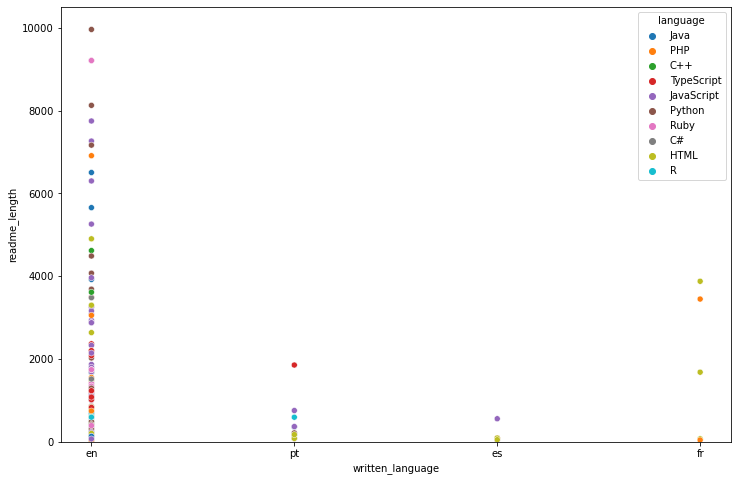

In [12]:

plt.figure(figsize=(12,8))

plt.ylim(0, 10500)
sns.scatterplot(data=df,x="written_language", y="readme_length", hue="language", )
plt.savefig("lang_scat.jpeg")
plt.show()

In [13]:
# get word frequencies for each language

js_freq = pd.Series(js).value_counts()
python_freq = pd.Series(python).value_counts()
html_freq = pd.Series(html).value_counts()
php_freq = pd.Series(php).value_counts()
cplus_freq = pd.Series(cplus).value_counts()
java_freq = pd.Series(java).value_counts()
csharp_freq = pd.Series(csharp).value_counts()
ts_freq = pd.Series(ts).value_counts()
ruby_freq = pd.Series(ruby).value_counts()
r_freq = pd.Series(r).value_counts()
c_freq = pd.Series(c).value_counts()
all_freq = pd.Series(all_words).value_counts()

<ipython-input-13-bef009e50d89>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c_freq = pd.Series(c).value_counts()


In [14]:
# Get a total word counts column by concating all langauge word frequencies.

word_counts = (pd.concat([all_freq,
                          js_freq,
                          python_freq,
                          html_freq,
                          php_freq,
                          cplus_freq,
                          java_freq,
                          csharp_freq,
                          ts_freq,
                          ruby_freq,
                         r_freq,
                         c_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'html', 'php','cplus', 'java', 'csharp', 'ts', 'ruby', 'r', 'c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))


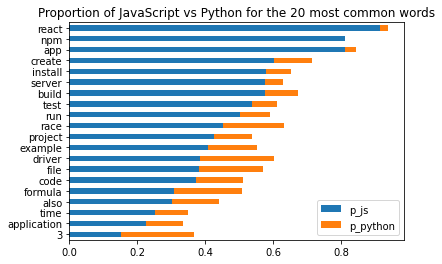

In [15]:
 # figure out the percentage of Javascript vs Python
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_python=word_counts.python / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Python for the 20 most common words')
plt.savefig("js_py_words.jpeg")
plt.show()

<h4>Takeaway</h4>

- Javascript & Python are the top two languages and they don't share too many common words


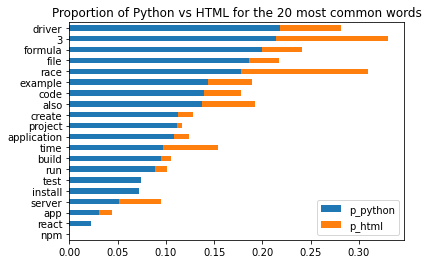

In [16]:
 # figure out the percentage of Python vs HTML
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_html']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs HTML for the 20 most common words')
plt.show()

<h4>Takeaway</h4>

- Python & HTML don't share many common words but the word data is present just as it was for Python and Javascript.
- Data will more than likley have a low TF-IDF score since it is appears that it will be frequent across many of the repositories.


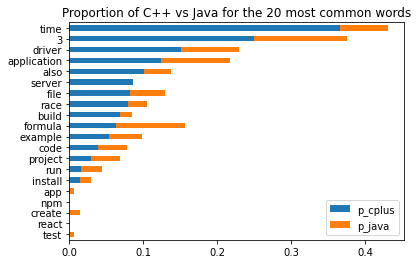

In [17]:
 # figure out the percentage of C ++ vs Java
(word_counts
 .assign(p_cplus=word_counts.cplus / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_cplus', 'p_java']]
 .tail(20)
 .sort_values('p_cplus')
 .plot.barh(stacked=True))

plt.title('Proportion of C++ vs Java for the 20 most common words')
plt.show()

<h4>Takeaway</h4>

- Again, data is present as we have seen previously
- 


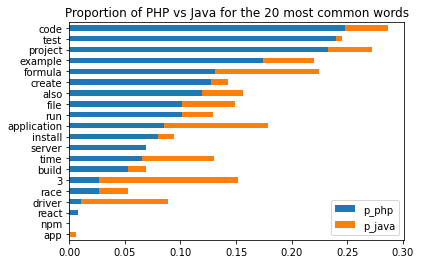

In [18]:
 # figure out the percentage of php vs java
(word_counts
 .assign(p_php=word_counts.php / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_php', 'p_java']]
 .tail(20)
 .sort_values('p_php')
 .plot.barh(stacked=True))

plt.title('Proportion of PHP vs Java for the 20 most common words')
plt.show()

<h4>Takeaway</h4>

- Java & PHP share application pretty evenly. 
- PHP also uses words like test & project


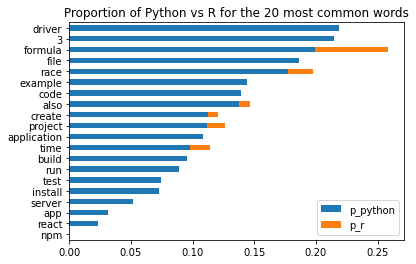

In [19]:
 # figure out the percentage of Python vs R
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_r=word_counts.r / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_r']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs R for the 20 most common words')
plt.show()

<h4>Takeaway</h4>

- I compared these two since both are used for Data Science. That said, I don't see many DS terms here between the two in common words



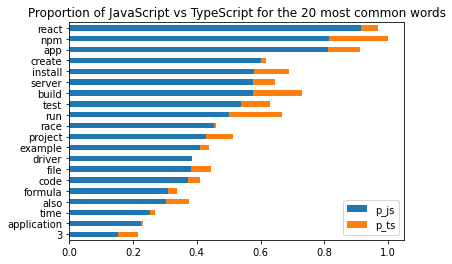

In [20]:
 # figure out the percentage of JavaScript vs TypeScript
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_ts=word_counts.ts / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_ts']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs TypeScript for the 20 most common words')
plt.show()

-------------

<h3>Bigrams</h3>

- let's look at a few bigrams of the top 3 languages to go more indepth into words being used

In [21]:
# convert javascript to one string

js = ' '.join([str(elem) for elem in js])

# bigrams for JavaScript

bigrams_js = nltk.ngrams(js.split(), 2)
top_20_js_bigrams = pd.Series(bigrams_js).value_counts().head(20)

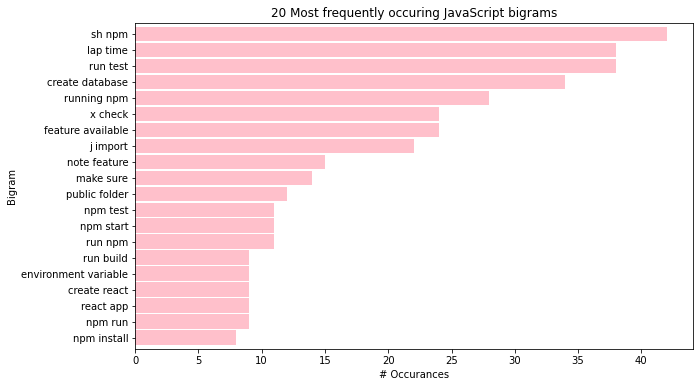

In [22]:
top_20_js_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [23]:
# convert python to one string

python = ' '.join([str(elem) for elem in python])

# bigrams for Python

bigrams_python = nltk.ngrams(python.split(), 2)
top_20_python_bigrams = pd.Series(bigrams_python).value_counts().head(20)

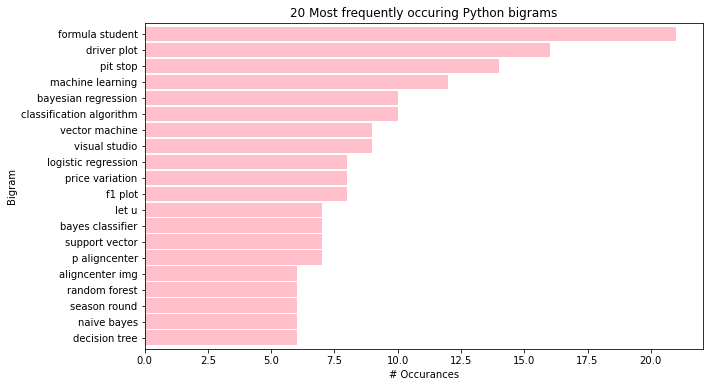

In [24]:
top_20_python_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)
plt.savefig("bigram_python.jpeg")

In [25]:
# convert html to one string

html = ' '.join([str(elem) for elem in html])

# bigrams for html

bigrams_html = nltk.ngrams(html.split(), 2)
top_20_html_bigrams = pd.Series(bigrams_html).value_counts().head(20)

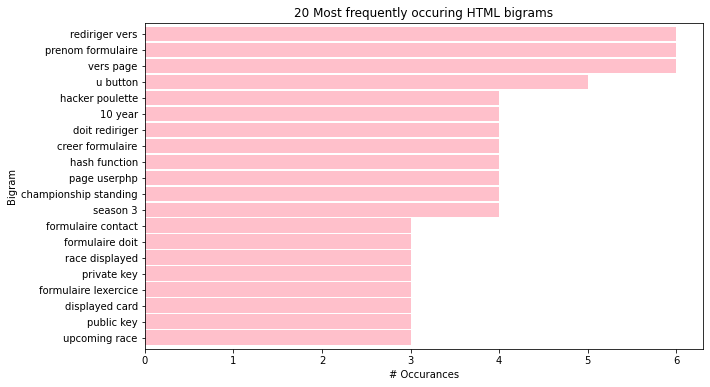

In [26]:
top_20_html_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [27]:
# convert html to one string

ts = ' '.join([str(elem) for elem in ts])

# bigrams for html

bigrams_ts = nltk.ngrams(ts.split(), 2)
top_20_ts_bigrams = pd.Series(bigrams_ts).value_counts().head(20)

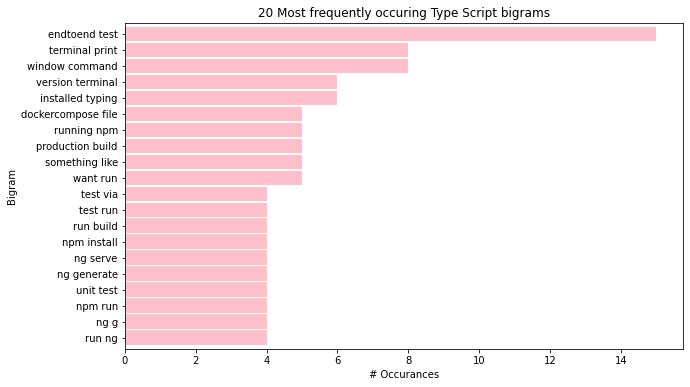

In [28]:
top_20_ts_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Type Script bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ts_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

---------

<h3>Trigrams</h3>

----------

In [29]:
# trigrams for JavaScript

trigrams_js = nltk.ngrams(js.split(), 3)
top_20_js_trigrams = pd.Series(trigrams_js).value_counts().head(20)

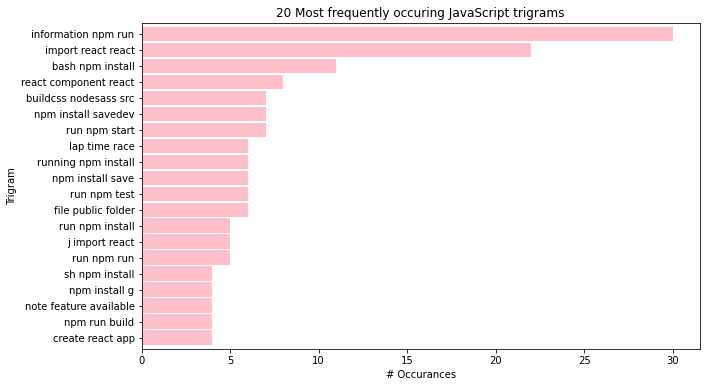

In [30]:
top_20_js_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2] )
_ = plt.yticks(ticks, labels)
plt.savefig("js_trigrams.jpeg")


In [31]:
# trigrams for Python

trigrams_python = nltk.ngrams(python.split(), 3)
top_20_python_trigrams = pd.Series(trigrams_python).value_counts().head(20)

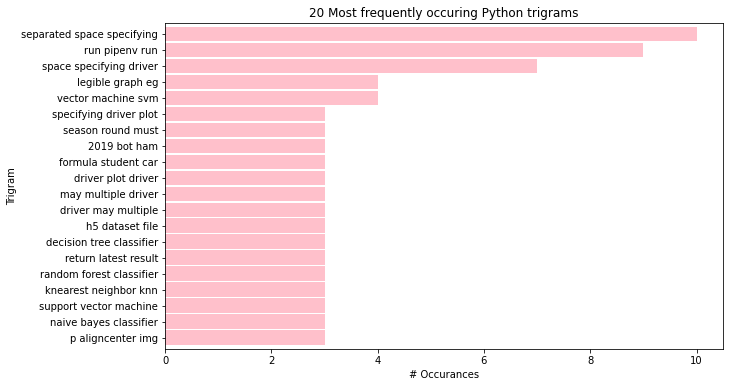

In [32]:
top_20_python_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [33]:
# trigrams for html

trigrams_html = nltk.ngrams(html.split(), 3)
top_20_html_trigrams = pd.Series(trigrams_html).value_counts().head(20)

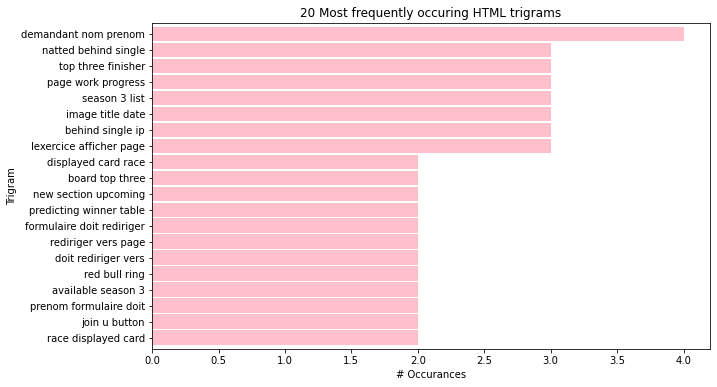

In [34]:
top_20_html_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

-----

<h3>Bigram/Trigram Takeaways</h3>

 - Computer languages like JavaScript and Python appear to have some unique words which should help the models distinguish these from the rest
 
 ---------

--------

<h3>Word Clouds</h3>

---------

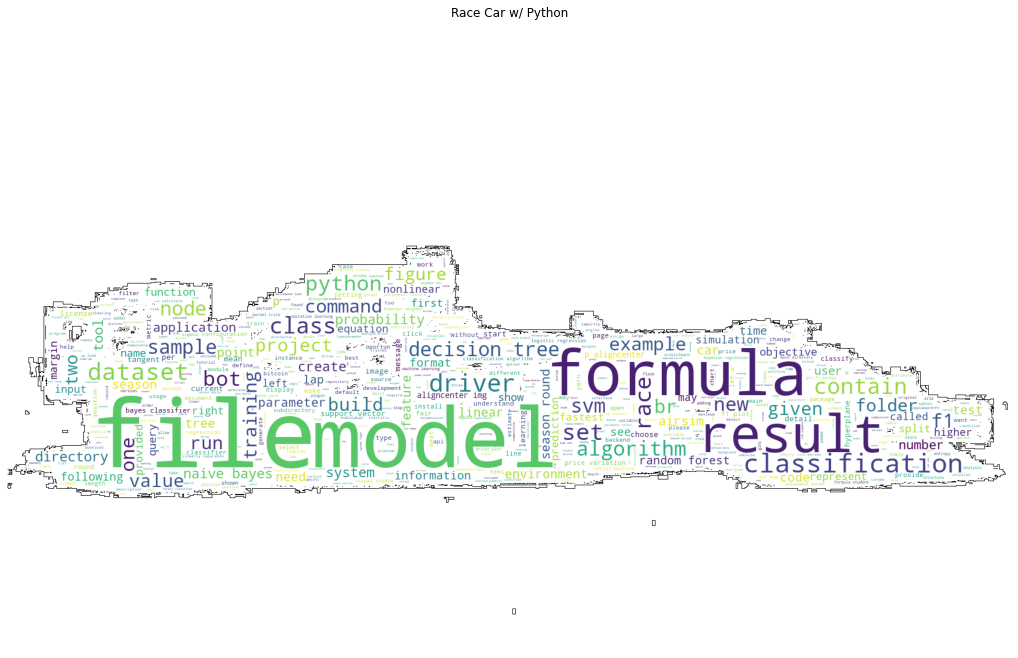

In [35]:
plt.figure(figsize=(18,12))
mask = np.array(Image.open('racecar.jpeg'))
img = WordCloud(background_color="white", mask=mask,contour_color='black', contour_width=.01,
                max_words=1250, max_font_size=256,
                random_state=42, width=800, height=800).generate(python)

# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Race Car w/ Python')
plt.savefig("racecar_wordmap.jpeg")
plt.show()

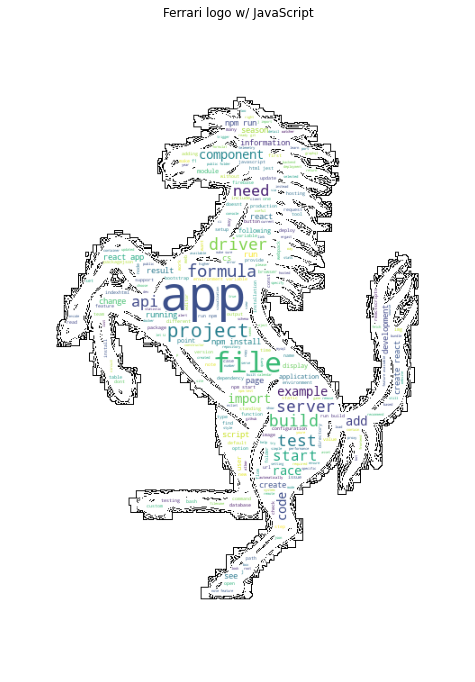

In [36]:
plt.figure(figsize=(18,12))
mask = np.array(Image.open('ferrari.jpeg'))
img = WordCloud(background_color="white", mask=mask,contour_color='black', contour_width=.5,
                max_words=1250, max_font_size=256,
                random_state=42, width=800, height=800).generate(js)

# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Ferrari logo w/ JavaScript')
plt.savefig("ferrari_wordmap.jpeg")

plt.show()

------

<h3>Word cloud takeaways</h3>

- Common words like data and formula populate many of the repositories, regardless of language type
- More unique words can be found like on the word cloud covering python...you can see words like naive bayes, decision tree, python, and probability. These are words that are specific to data science and python


---------

<h3> Train the Data</h3>

--------

In [37]:
df.readme_contents = df.readme_contents.apply(clean_final)

In [38]:
train, validate, test = split(df, 'language')

In [39]:
train.shape, validate.shape, test.shape

((98, 5), (43, 5), (36, 5))

-----
<h3> Establish a Baseline </h3>

-----

In [40]:
# The most frequenly observed outcome will be our baseline

train.language.value_counts()

JavaScript    28
Python        15
HTML          11
C++            8
Java           7
TypeScript     7
PHP            7
Ruby           6
C#             5
R              4
Name: language, dtype: int64

In [41]:
baseline_accuracy = (round((train.language == 'JavaScript').mean(), 2)* 100)

print(f'Our baseline accuracy is {baseline_accuracy}%')

Our baseline accuracy is 28.999999999999996%


---------

<h3> Model the Data</h3>

--------

In [42]:
# Setup our X variables
X_train = train.readme_contents
X_validate = validate.readme_contents
X_test = test.readme_contents

In [43]:
# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [44]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

In [45]:
# Fit on the training data
tfidf.fit(X_train)

TfidfVectorizer()

In [46]:
# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [47]:
# Sparse vectors/matrices have tons of zeros
X_train_vectorized.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.14504498, 0.        ,
         0.        ]])

In [48]:
X_train_vectorized.todense().shape

(98, 4389)

------

## Logistic Regression

------

In [49]:
# Now that we have a vectorized dataset, we can use our classification tools!
lm = LogisticRegression()

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression()

In [50]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [51]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [52]:
# Since we .fit on a subset, we .predict on that same subset of features
y_pred = lm.predict(X_train_vectorized)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lm.score(X_train_vectorized, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.59


In [53]:
y_pred = lm.predict(X_validate_vectorized)

print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(lm.score(X_validate_vectorized, y_validate)))

Accuracy of Logistic Regression classifier on validate set: 0.30


In [54]:
# Train Accuracy
(train.actual == train.predicted).mean()

0.5918367346938775

In [55]:
# Out of sample accuracy
(validate.actual == validate.predicted).mean()

0.3023255813953488

In [56]:
languages = train.actual.value_counts().index.tolist()

In [57]:
for language in languages:
    language_lines = train[train.actual == language]
    accuracy = (language_lines.actual == language_lines.predicted).mean()
    print(f"Predicting {language} has {round(accuracy, 2)}")

Predicting JavaScript has 1.0
Predicting Python has 0.93
Predicting HTML has 0.91
Predicting C++ has 0.0
Predicting Java has 0.0
Predicting TypeScript has 0.57
Predicting PHP has 0.0
Predicting Ruby has 0.33
Predicting C# has 0.0
Predicting R has 0.0


-----

<h3>Takeaway</h3>

- So promising with the train dataset but it fell with the validate. Great job predicting JS, Python & HTML on train data set but nothing for other languages minus TypeScript and Ruby

------

----------

## Random Forest

----------

In [58]:
# create the Random Forest Model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [59]:
# Fit the classification model on our vectorized train data
rf.fit(X_train_vectorized, y_train)


RandomForestClassifier(max_depth=10, random_state=123)

In [60]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = rf.predict(X_train_vectorized)
validate["predicted"] = rf.predict(X_validate_vectorized)
test['predicted'] = rf.predict(X_test_vectorized)

In [61]:
# Train Accuracy
(train.actual == train.predicted).mean()

0.7346938775510204

In [62]:
# Out of sample accuracy
(validate.actual == validate.predicted).mean()

0.37209302325581395

In [63]:
for language in languages:
    language_lines = train[train.actual == language]
    accuracy = (language_lines.actual == language_lines.predicted).mean()
    print(f"Predicting {language} has {round(accuracy, 2)}")

Predicting JavaScript has 1.0
Predicting Python has 0.6
Predicting HTML has 0.45
Predicting C++ has 0.62
Predicting Java has 0.57
Predicting TypeScript has 0.86
Predicting PHP has 0.71
Predicting Ruby has 0.67
Predicting C# has 0.6
Predicting R has 0.75


-----

<h3>Takeaway</h3>

- I really though this would be the model to go with but the drop from train to validate was too much. 

------

-------

## KNN Model

-------

In [64]:
# Now let's make the model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [65]:
# Now let's train the model!
knn.fit(X_train_vectorized, y_train)

KNeighborsClassifier()

In [66]:
y_pred = knn.predict(X_train_vectorized)

In [67]:
y_pred_proba = knn.predict_proba(X_train_vectorized)

In [68]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train_vectorized, y_train)))

Accuracy of KNN classifier on training set: 0.51


In [69]:
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate_vectorized, y_validate)))

Accuracy of KNN classifier on validate set: 0.35


In [70]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = knn.predict(X_train_vectorized)
validate["predicted"] = knn.predict(X_validate_vectorized)
test['predicted'] = knn.predict(X_test_vectorized)

In [71]:
for language in languages:
    language_lines = train[train.actual == language]
    accuracy = (language_lines.actual == language_lines.predicted).mean()
    print(f"Predicting {language} has {round(accuracy, 2)}")

Predicting JavaScript has 0.96
Predicting Python has 0.33
Predicting HTML has 0.73
Predicting C++ has 0.38
Predicting Java has 0.0
Predicting TypeScript has 0.14
Predicting PHP has 0.29
Predicting Ruby has 0.17
Predicting C# has 0.6
Predicting R has 0.0


In [72]:
from sklearn.metrics import classification_report
print(classification_report(train.actual, train.predicted))

              precision    recall  f1-score   support

          C#       0.33      0.60      0.43         5
         C++       0.50      0.38      0.43         8
        HTML       0.80      0.73      0.76        11
        Java       0.00      0.00      0.00         7
  JavaScript       0.46      0.96      0.62        28
         PHP       1.00      0.29      0.44         7
      Python       0.83      0.33      0.48        15
           R       0.00      0.00      0.00         4
        Ruby       0.33      0.17      0.22         6
  TypeScript       0.50      0.14      0.22         7

    accuracy                           0.51        98
   macro avg       0.48      0.36      0.36        98
weighted avg       0.53      0.51      0.45        98



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----

<h3>Takeaway</h3>

- This model doesn't blow you away on the train dataset but it holds its own and it is decent on the validate. 
- When looking at the individual accuracies, this model almost predicted every language in some shape or form minus R and Java


------

-------

<h3>Decision Tree</h3>

--------

In [73]:
clf = DecisionTreeClassifier(max_depth=6, random_state=123)

In [74]:
# Now let's train our model on the training data
# fitting == training the model
clf = clf.fit(X_train_vectorized, y_train)

In [75]:
# Now we'll make a set of predictions using this trained model
y_pred = clf.predict(X_train_vectorized)

In [76]:
# Estimate the probabilities for each class
y_pred_proba = clf.predict_proba(X_train_vectorized)

In [77]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = clf.predict(X_train_vectorized)
validate["predicted"] = clf.predict(X_validate_vectorized)
test['predicted'] = clf.predict(X_test_vectorized)

In [78]:
for language in languages:
    language_lines = train[train.actual == language]
    accuracy = (language_lines.actual == language_lines.predicted).mean()
    print(f"Predicting {language} has {round(accuracy, 2)}")

Predicting JavaScript has 1.0
Predicting Python has 0.4
Predicting HTML has 0.36
Predicting C++ has 0.0
Predicting Java has 0.0
Predicting TypeScript has 0.57
Predicting PHP has 0.0
Predicting Ruby has 0.5
Predicting C# has 0.0
Predicting R has 0.0


In [79]:
# Let's evaluate the model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train_vectorized, y_train)))

Accuracy of Decision Tree classifier on training set: 0.46


In [80]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate_vectorized, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.35


-----

<h3>Takeaway</h3>

- Decision Tree just wasn't doing much and was not going to be a better option than KNN

------

----

<h3>Comparative Look At Train & Validate Accuracy</h3>

-----

In [81]:

logreg_train_accuracy = lm.score(X_train_vectorized, y_train)
decisiontree_train_accuracy = clf.score(X_train_vectorized, y_train)
random_forest_train_accuracy = rf.score(X_train_vectorized, y_train)
knn_train_accuracy = knn.score(X_train_vectorized, y_train)

logreg_validate_accuracy = lm.score(X_validate_vectorized, y_validate)
decisiontree_validate_accuracy = clf.score(X_validate_vectorized, y_validate)
random_forest_validate_accuracy = rf.score(X_validate_vectorized, y_validate)
knn_validate_accuracy = knn.score(X_validate_vectorized, y_validate)
print('\n')
print(f'The baseline accuracy is {baseline_accuracy}%')
print('\n')

print(f"Logistic Regression Train Accuracy --- {logreg_train_accuracy:.2%}")
print(f"Decision Tree Train Accuracy --- {decisiontree_train_accuracy:.2%}")
print(f"Random Forest Train Accuracy --- {random_forest_train_accuracy:.2%}")
print(f"KNN Accuracy Train Accuracy --- {knn_train_accuracy:.2%}")
print('\n')
print(f"Logistic Regression Validate Accuracy --- {logreg_validate_accuracy:.2%}")
print(f"Decision Tree Validate Accuracy --- {decisiontree_validate_accuracy:.2%}")
print(f"Random Forest Validate Accuracy --- {random_forest_validate_accuracy:.2%}")
print(f"KNN Validate Accuracy --- {knn_validate_accuracy:.2%}")



The baseline accuracy is 28.999999999999996%


Logistic Regression Train Accuracy --- 59.18%
Decision Tree Train Accuracy --- 45.92%
Random Forest Train Accuracy --- 73.47%
KNN Accuracy Train Accuracy --- 51.02%


Logistic Regression Validate Accuracy --- 30.23%
Decision Tree Validate Accuracy --- 34.88%
Random Forest Validate Accuracy --- 37.21%
KNN Validate Accuracy --- 34.88%


------

<h3>Test Accuracy</h3>

- I chose to move forward with the KNN model as it seemed to perform the best from Train to Validate

- Random Forest did great on the train dataset but dropped off significantly on validate which makes me believe it might be slightly over fit.,

- After testing KNN, it performed with a 36.11% accuracy on the test data. This beat the baseline of 29% earlier although from a birds eye view, it has a lot of room for improvement. I will outline the reasons for the poor performance in the Key Takeways coming up next

-----

In [82]:
KNN_accuracy = knn.score(X_test_vectorized, y_test)
print(f"KNN Accuracy --- {KNN_accuracy:.2%}")

KNN Accuracy --- 36.11%


--------

<h3>Key Takeaways, Recommendations, & Next Steps</h3>

Through this classification project I came away with the following <b> key takeways</b>:

- The higher the number of repositories with a certain language, the better the model is at predicting it
     - We saw this with the high accuracies for our top 3 languages by value_counts (JavaScript, Python, HTML)
- JS, Python, & HTML also each had repositories in different languages so it's hard to make an argument that language played a factor as those language specific stopwords were accounted for in the cleaning of the data
- I thought having repositories in different langauages would affect the accuracy but as it turns out, that didn't seem to be an issue as the top 3 languages (JS, Python, HTML) all had repositories in multiple languages.

<b>Recommendations & next steps</b>:

- More repositories will increase the sample size and will allow for greater accuracy
- Going with repositories that focused on Formula 1 was off the main path and it lead to issues with not only empty repositories but poorly constructed README files as well.
- Going forward, this model could be improved further by limiting the number of languages to a top 5 


In [83]:
df.head()

,repo,language,readme_contents,written_language,readme_length
0,ppatierno/formula1-telemetry-kafka,Java,formula 1 telemetry apache kafka project aim u...,en,6504
2,jcnewell/ergast-f1-api,PHP,ergast nodejs api period working improve serve...,en,1722
5,izenecloud/sf1r-lite,C++,sf1rlitesearch formula1 lite engine distribute...,en,4619
7,jonybur/f1-telemetry-client,TypeScript,f1 telemetry client img srchttpsimgshieldsionp...,en,3495
8,davidor/formula1-lap-charts,JavaScript,formula 1 lap chart interactive lap chart visu...,en,1506


In [84]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 267
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              177 non-null    object
 1   language          177 non-null    object
 2   readme_contents   177 non-null    object
 3   written_language  177 non-null    object
 4   readme_length     177 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 8.3+ KB
